## This is a simple way for calculating and projecting LTV ( Life Time Value) for free-to-play platform/game.

1. We should read and analyze data sample where we can aquire the following data: useer ID, game installation date, day of payment and ampunt of payment for user on the payment day.
2. We need to:
a)Perform a little data ebgineering
b) Identify the best function for LTV projection
c) Find the polynom coefficient and project values for LTV90 and LTV180 where LTV{N} forecast of LTV value for the day N
d) COnsidering that out player life time is 180 days, we need to calculate the coefficients K1, K3, K7, K30 and K180, where K{N} is the ratio between revenue by day N and LTV180.


In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import optimize
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
data = pd.read_csv('sq_data.csv')

In [8]:
print (data.shape)

(10, 4)


In [9]:
data.head()

,user,install_date,pay_date,sum
0,asdre5961,1/1/2018,1/1/2018,0.99
1,fdsfsd1895,1/1/2018,20/01/2018,4.95
2,rhuyn4346,3/1/2018,5/1/2018,0.99
3,asdre5961,1/1/2018,3/1/2018,3.97
4,rhuyn4346,3/1/2018,19/01/2018,0.99


In [10]:
data['install_date'] = pd.to_datetime(data['install_date'],dayfirst = True)
data['pay_date'] = pd.to_datetime(data['pay_date'], dayfirst = True)

In [11]:
data = data.sort_values('pay_date')

In [12]:
def get_cum_sum(date):
    return data['sum'].where(data['pay_date']<=date).sum()

data['cum_sum'] = data['pay_date'].map(lambda x: get_cum_sum(x))

In [13]:
def get_users_utd(date):
    return data['user'].where(data['install_date'] <=date).count()

data['users_n_utd'] = data['pay_date'].map(lambda x: get_users_utd(x))

In [14]:
data['ltv'] = data['cum_sum']/data['users_n_utd'].astype(float)

In [15]:
data['day'] = pd.to_timedelta(data['pay_date'] - data['install_date'].min()).dt.days + 1
data['day'] = data['day'].astype(int)

In [16]:
data.head(20)

,user,install_date,pay_date,sum,cum_sum,users_n_utd,ltv,day
0,asdre5961,2018-01-01,2018-01-01,0.99,0.99,5,0.198000,1
3,asdre5961,2018-01-01,2018-01-03,3.97,4.96,7,0.708571,3
2,rhuyn4346,2018-01-03,2018-01-05,0.99,5.95,7,0.850000,5
6,asdre5961,2018-01-01,2018-01-07,0.99,6.94,9,0.771111,7
8,fdsvf897,2018-01-10,2018-01-11,4.95,11.89,10,1.189000,11
5,frergr8715,2018-01-07,2018-01-12,0.99,12.88,10,1.288000,12
4,rhuyn4346,2018-01-03,2018-01-19,0.99,13.87,10,1.387000,19
1,fdsfsd1895,2018-01-01,2018-01-20,4.95,18.82,10,1.882000,20
9,asdre5961,2018-01-01,2018-01-30,0.99,19.81,10,1.981000,30
7,frergr8715,2018-01-07,2018-02-02,0.99,20.80,10,2.080000,33


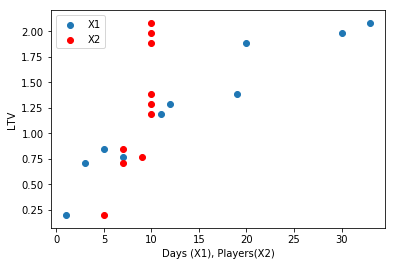

In [22]:
plt.scatter(data['day'], data['ltv'])
plt.scatter(data['users_n_utd'], data['ltv'], color='r')
plt.xlabel('Days (X1), Players(X2)')
plt.ylabel('LTV')
plt.legend(['X1', 'X2'])

In [23]:
ltv_data = data[['day','users_n_utd', 'ltv']]
X = ltv_data[['day', 'users_n_utd']]
y = ltv_data['ltv']

In [24]:
from sklearn import linear_model
from sklearn import metrics

predictor = linear_model.LinearRegression()
predictor.fit(X, y)
y_p = predictor.predict(X)

mse = metrics.mean_squared_error(y,y_p)
print (mse)

0.02063250293864264


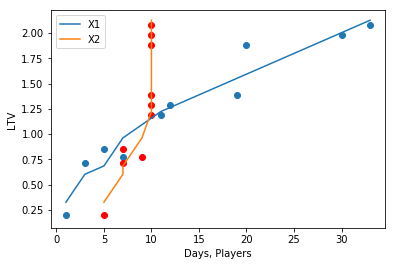

In [25]:
plt.scatter(X['day'].values,y)
plt.scatter(X['users_n_utd'].values,y, color = 'r')
plt.plot(X['day'].values, y_p)
plt.plot(X['users_n_utd'].values, y_p)
plt.xlabel('Days, Players')
plt.ylabel('LTV')
plt.legend(['X1', 'X2'])

In [16]:
predictor.coef_

array([0.04107311, 0.09776538])

In [17]:
predictor.intercept_

-0.20599793299793334

Text(0,0.5,'Players')

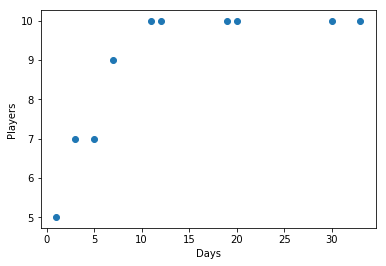

In [26]:
plt.scatter(X['day'].values,X['users_n_utd'].values)
plt.xlabel('Days')
plt.ylabel('Players')

In [27]:
X_u = X['day'].values 
Y_u = X['users_n_utd'].values

coefs, cov = optimize.curve_fit(lambda t,a,b: a+b*np.log(t),  X_u,  Y_u)

print (coefs)

[5.35053276 1.54168625]


Text(0,0.5,'Игроки')

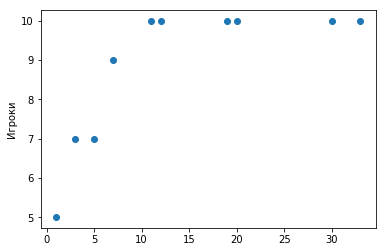

In [28]:
plt.scatter(X['day'].values,X['users_n_utd'].values)
plt.ylabel(u'Игроки')

In [29]:
def players_func(param):
    result = []
    result = coefs[0] + coefs[1]*np.log(param)
    return result
    

users_90_180 = players_func([90., 180.])
u90 = int(round(users_90_180[0],0))
u180 = int(round(users_90_180[1],0))

print (u90)
print (u180)

12
13


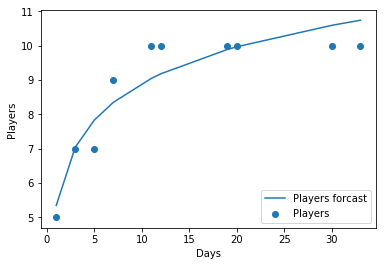

In [30]:
plt.scatter(X['day'].values,X['users_n_utd'].values)
plt.plot(X['day'].values,players_func(X['day'].values.reshape(-1, 1)))
plt.xlabel('Days')
plt.ylabel('Players')
plt.legend(['Players forcast', 'Players'])

In [31]:
X_90_180 = pd.DataFrame([[90, u90],[180, u180]], columns = ['day', 'users_n_utd'])

In [32]:
y_90_180 = predictor.predict(X_90_180)
LTV_90 = round(y_90_180[0],2)
LTV_180 = round(y_90_180[1],2)

In [33]:
print ("LTV90: " + str(LTV_90))
print ("LTV180: " + str(LTV_180))

LTV90: 4.66
LTV180: 8.46


In [34]:
k_days = [1, 3, 7, 30]
K180 = round(LTV_180/(LTV_180 * u180), 2)
ks= []
rev = []
for k in k_days:
    day_ltv = ltv_data['ltv'].loc[ltv_data['day'] == k].values[0]
    day_u = ltv_data['users_n_utd'].loc[ltv_data['day'] == k].values[0]
    K_revenue = (day_ltv*day_u)
    coeff = LTV_180/K_revenue
    ks.append(coeff)
    rev.append(day_u)
    print ("K" + str(k) + ": " + str(round(coeff, 2)))

print ("K180: " + str(K180)) 


K1: 8.55
K3: 1.71
K7: 1.22
K30: 0.43
K180: 0.08


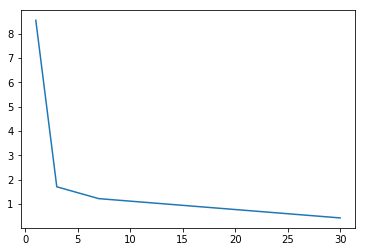

In [35]:
plt.plot(k_days, ks)